## Data Import

In [27]:
# import os, pandas as pd

# # Add asset from file system

# print(os.environ['DSX_PROJECT_DIR']+'/datasets/filename')

In [ ]:
#Code to install imbalanced-learn. Credits: Ernest

# 1. Download imbalanced-learn from https://files.pythonhosted.org/packages/e5/4c/7557e1c2e791bd43878f8c82065bddc5798252084f26ef44527c02262af1/imbalanced_learn-0.4.3-py3-none-any.whl 
# 2. Add it to the part where we add datasets

# !pip install --user '/user-home/1022/DSX_Projects/Naive Baes/datasets/imbalanced_learn-0.4.3-py3-none-any.whl'

# Install missingno
# !pip install --user '/user-home/1022/DSX_Projects/Naive Baes/datasets/missingno-0.4.1-py3-none-any.whl'

# Install mlxtend
# !pip install --user '/user-home/1022/DSX_Projects/Naive Baes/datasets/mlxtend-0.15.0.0-py2.py3-none-any.whl'

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import matplotlib.patches as mpatches # plot t-SNE, PCA, Truncated SVD
import missingno as msno

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs # feature selection

import seaborn as sns 

from imblearn.over_sampling import SMOTE

from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
from scipy.stats import norm
import numbers 

import pylab # t-SNE 
import time # t-SNE model
from sklearn.manifold import TSNE # t-SNE
from sklearn.decomposition import PCA, TruncatedSVD # PCA, SVD

In [3]:
# #Code to import dataset
# df = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/creditcard-training.csv')
# df.head()

In [4]:
df_raw = pd.read_csv('data/creditcard-training.csv')

# Data Exploration

In [5]:
#Get shape
df_raw.shape

(227844, 32)

In [6]:
#Print head
df_raw.head()

,Seconds since reference time,Amount,"Fraud? (1: Fraud, 0: No Fraud)",Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,0,149.62,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,...,0.462388,0.239599,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787
1,0,2.69,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,...,-0.082361,-0.078803,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425
2,1,378.66,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,...,1.800499,0.791461,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654
3,1,123.50,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,...,1.247203,0.237609,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024
4,2,69.99,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,...,0.095921,0.592941,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739


In [7]:
#Rename the fraud column
df_raw = df_raw.rename( {'Fraud? (1: Fraud, 0:  No Fraud)' : 'Fraud'}, axis=1)
df_raw.head()

,Seconds since reference time,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,0,149.62,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,...,0.462388,0.239599,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787
1,0,2.69,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,...,-0.082361,-0.078803,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425
2,1,378.66,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,...,1.800499,0.791461,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654
3,1,123.50,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,...,1.247203,0.237609,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024
4,2,69.99,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,...,0.095921,0.592941,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739


In [8]:
#Get NAs 
df_raw[df_raw.isnull().any(axis=1)].head()

,Seconds since reference time,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
10,10,7.80,0,0.230930,0.031967,0.253415,0.854344,NaN,-0.387226,-0.009302,...,-0.629152,-1.423236,0.048456,-13.640428,-0.095045,-0.513947,-0.671440,1.199644,1.626659,-1.720408
16,12,12.99,0,0.354574,-0.246635,-0.009212,-0.595912,-0.575682,NaN,-0.024612,...,0.288069,-0.586057,0.189380,8.579468,-0.468647,0.708380,0.936708,-0.450311,-0.267975,0.782333
25,22,26.43,0,-0.211668,-0.333321,0.010751,-0.488473,0.505751,NaN,-0.403639,...,-0.959537,0.543985,-0.104627,-10.985595,-0.279797,-0.655233,-0.180523,-0.856566,0.149451,0.475664
28,23,33.00,0,0.076804,-1.405919,0.775592,-0.942889,NaN,0.097308,0.077237,...,-0.200331,0.740228,-0.029247,-5.123601,-0.086324,0.635954,0.786796,-0.012142,-0.346188,-0.593392
42,33,14.80,0,0.235545,-1.347811,0.504648,-0.798405,0.759710,NaN,-0.087329,...,0.119168,0.850893,-0.176267,5.560997,-0.365439,0.481917,0.398299,-0.387003,0.148455,-0.243501


Text(0,0.5,'Frequency')

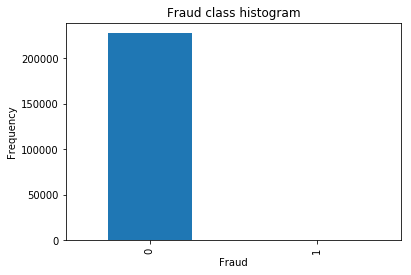

In [9]:
#EDA

#Checking the Target Classes
count_classes = pd.value_counts(df_raw['Fraud'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Fraud")
plt.ylabel("Frequency")

#The historgram shows that there is a need for resampling 


## Data Cleaning

In [10]:
#Since the value of amount has a very different scale from the rest, we should condier normalising the column "amount"
#Method 1 Drop Seconds Since Reference Time Column
#Seconds since reference time column will be dropped as well since it has no significant contribution to the model building as it is simply a cheorogrphical order of the reference time
#df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
#df = df.drop(['Seconds since reference time','Amount'],axis=1)
#df.head()

df = df_raw.copy()
#Method 2 Normalize Seconds Since Reference Time Column
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['normTime'] = StandardScaler().fit_transform(df['Seconds since reference time'].values.reshape(-1, 1))
df = df.drop(['Amount'],axis=1)
df.head()
df = df.drop(['Seconds since reference time'],axis=1)

#Deciding which method to choose depends on ?????


C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Outlier Removal

In [11]:
#Information on Column Types, No of Null Values, Min, Max 
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'Column Type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info=tab_info.append(pd.DataFrame(df.min()).T.rename(index={0:'min value (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.max()).T.rename(index={0:'max value (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.max()-df.min()).T.rename(index={0:'range (nb)'}))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(tab_info)

                  Fraud Feature 1 Feature 2 Feature 3 Feature 4  Feature 5  \
Column Type       int64   float64   float64   float64   float64    float64   
null values (nb)      0         0         0         0         0         27   
null values (%)       0         0         0         0         0  0.0118502   
min value (nb)        0  -4.49894  -14.1299  -25.1628  -9.49875   -7.21353   
max value (nb)        1   5.82565   8.28989   9.25353   5.04107    5.59197   
range (nb)            1   10.3246   22.4197   34.4163   14.5398    12.8055   

                  Feature 6 Feature 7 Feature 8 Feature 9 Feature 10  \
Column Type         float64   float64   float64   float64    float64   
null values (nb)         59         0         0         0          0   
null values (%)   0.0258949         0         0         0          0   
min value (nb)     -28.0096  -34.8304  -10.9331  -44.8077   -2.83663   
max value (nb)      39.4209   27.2028   10.5031   19.0029    4.02287   
range (nb)          6

C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


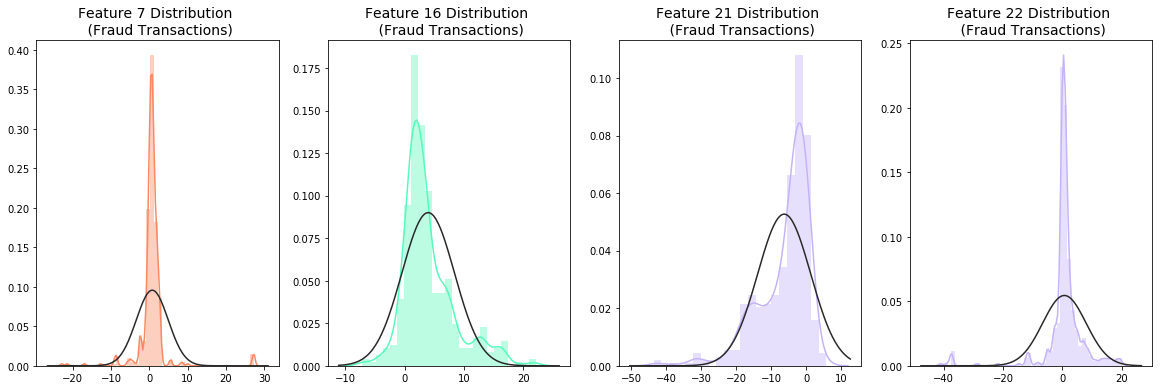

In [12]:
#Anomaly Detection 
#Plot Outliers in Boxplot and Remove Outliers 

from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

v7_fraud_dist = df['Feature 7'].loc[df['Fraud'] == 1].values
sns.distplot(v7_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Feature 7 Distribution \n (Fraud Transactions)', fontsize=14)

v16_fraud_dist = df['Feature 16'].loc[df['Fraud'] == 1].values
sns.distplot(v16_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Feature 16 Distribution \n (Fraud Transactions)', fontsize=14)

v21_fraud_dist = df['Feature 21'].loc[df['Fraud'] == 1].values
sns.distplot(v21_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Feature 21 Distribution \n (Fraud Transactions)', fontsize=14)

v22_fraud_dist = df['Feature 22'].loc[df['Fraud'] == 1].values
sns.distplot(v22_fraud_dist,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('Feature 22 Distribution \n (Fraud Transactions)', fontsize=14)


plt.show()

In [13]:
# Feature 7 removing outliers from fraud transactions
v7_fraud = df['Feature 7'].loc[df['Fraud'] == 1].values
q25, q75 = np.percentile(v7_fraud, 25), np.percentile(v7_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v7_iqr = q75 - q25
print('iqr: {}'.format(v7_iqr))

v7_cut_off = v7_iqr * 1.5
v7_lower, v7_upper = q25 - v7_cut_off, q75 + v7_cut_off
print('Cut Off: {}'.format(v7_cut_off))
print('Feature 14 Lower: {}'.format(v7_lower))
print('Feature 14 Upper: {}'.format(v7_upper))

outliers = [x for x in v7_fraud if x < v7_lower or x > v7_upper]
print('Feature 7 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('Feature 7 outliers:{}'.format(outliers))

df = df.drop(df[(df['Feature 7'] > v7_upper) | (df['Feature 7'] < v7_lower)].index)
print('----' * 44)

# Feature 16 removing outliers from fraud transactions
v16_fraud = df['Feature 16'].loc[df['Fraud'] == 1].values
q25, q75 = np.percentile(v16_fraud, 25), np.percentile(v16_fraud, 75)
v16_iqr = q75 - q25

v16_cut_off = v16_iqr * 1.5
v16_lower, v16_upper = q25 - v16_cut_off, q75 + v16_cut_off
print('Feature 16 Lower: {}'.format(v16_lower))
print('Feature 16 Upper: {}'.format(v16_upper))
outliers = [x for x in v16_fraud if x < v16_lower or x > v16_upper]
print('Feature 16 outliers: {}'.format(outliers))
print('Feature 16 Outliers for Fraud Cases: {}'.format(len(outliers)))
df = df.drop(df[(df['Feature 16'] > v16_upper) | (df['Feature 16'] < v16_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(df)))
print('----' * 44)

# Feature 21 removing outliers from fraud transactions
v21_fraud = df['Feature 21'].loc[df['Fraud'] == 1].values
q25, q75 = np.percentile(v21_fraud, 25), np.percentile(v21_fraud, 75)
v21_iqr = q75 - q25

v21_cut_off = v21_iqr * 1.5
v21_lower, v21_upper = q25 - v21_cut_off, q75 + v21_cut_off
print('Feature 21 Lower: {}'.format(v21_lower))
print('Feature 21 Upper: {}'.format(v21_upper))
outliers = [x for x in v21_fraud if x < v21_lower or x > v21_upper]
print('Feature 21 outliers: {}'.format(outliers))
print('Feature 21 Outliers for Fraud Cases: {}'.format(len(outliers)))
df = df.drop(df[(df['Feature 21'] > v21_upper) | (df['Feature 21'] < v21_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(df)))
print('----' * 44)

# Feature 22 removing outliers from fraud transactions
v22_fraud = df['Feature 22'].loc[df['Fraud'] == 1].values
q25, q75 = np.percentile(v22_fraud, 25), np.percentile(v22_fraud, 75)
v22_iqr = q75 - q25

v22_cut_off = v22_iqr * 1.5
v22_lower, v22_upper = q25 - v22_cut_off, q75 + v22_cut_off
print('Feature 22 Lower: {}'.format(v22_lower))
print('Feature 22 Upper: {}'.format(v22_upper))
outliers = [x for x in v22_fraud if x < v22_lower or x > v22_upper]
print('Feature 22 outliers: {}'.format(outliers))
print('Feature 22 Outliers for Fraud Cases: {}'.format(len(outliers)))
df = df.drop(df[(df['Feature 22'] > v22_upper) | (df['Feature 22'] < v22_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(df)))

Quartile 25: 0.015255353999999999 | Quartile 75: 1.441622275
iqr: 1.426366921
Cut Off: 2.1395503815000003
Feature 14 Lower: -2.1242950275000005
Feature 14 Upper: 3.5811726565000006
Feature 7 Outliers for Fraud Cases: 42
Feature 7 outliers:[-2.475962229, -2.444883682, -2.366836062, -2.362344928, -2.356896279, -2.350633745, -2.343673594, -2.3361109559999997, -2.328024416, -2.319479462, -2.182691946, -2.4571448730000003, 27.20283916, 27.20283916, 27.20283916, 27.20283916, 27.20283916, 27.20283916, -2.5044501869999998, 10.00599801, 8.280439326, -8.755698321, -8.755698321, -8.755698321, -8.755698321, -3.474096503, -4.884982624, -4.969477722, -5.688990272000001, -5.49877168, -4.300431866, -4.352213131, -8.228874098, -9.110422576, 5.4536718529999995, -12.61502286, -16.92201578, -21.45373628, -22.79760391, 5.5566423910000005, 5.563300664, 8.66466243]
-------------------------------------------------------------------------------------------------------------------------------------------------

C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


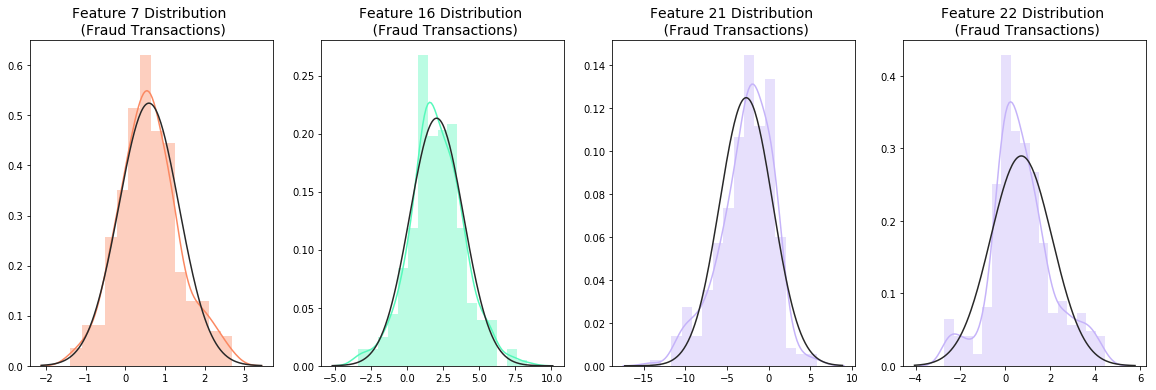

In [14]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

v7_fraud_dist = df['Feature 7'].loc[df['Fraud'] == 1].values
sns.distplot(v7_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Feature 7 Distribution \n (Fraud Transactions)', fontsize=14)

v16_fraud_dist = df['Feature 16'].loc[df['Fraud'] == 1].values
sns.distplot(v16_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Feature 16 Distribution \n (Fraud Transactions)', fontsize=14)

v21_fraud_dist = df['Feature 21'].loc[df['Fraud'] == 1].values
sns.distplot(v21_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Feature 21 Distribution \n (Fraud Transactions)', fontsize=14)

v22_fraud_dist = df['Feature 22'].loc[df['Fraud'] == 1].values
sns.distplot(v22_fraud_dist,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('Feature 22 Distribution \n (Fraud Transactions)', fontsize=14)


plt.show()

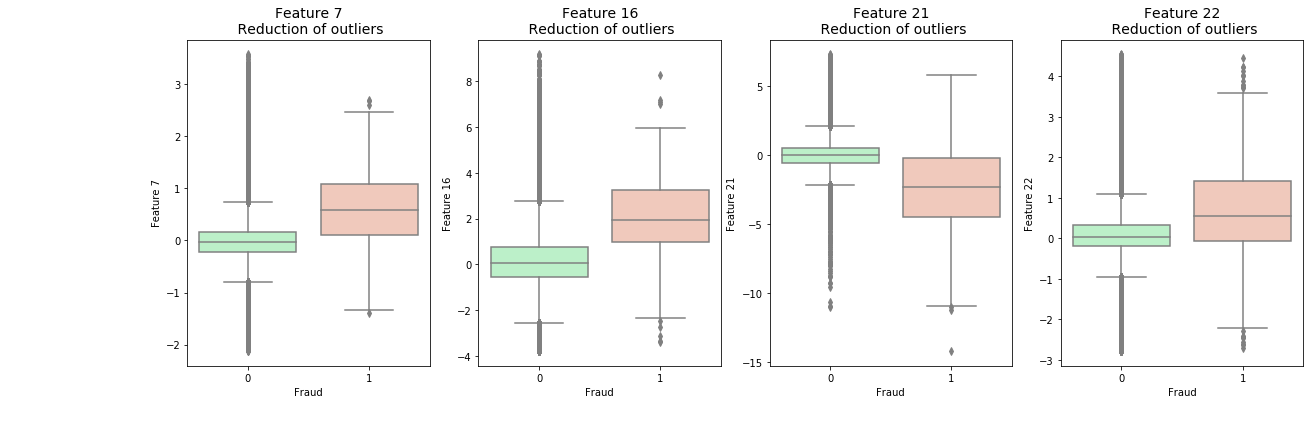

In [15]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']

# Boxplots with outliers removed
# Feature 7
sns.boxplot(x="Fraud", y="Feature 7", data=df,ax=ax1, palette=colors)
ax1.set_title("Feature 7\n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 16
sns.boxplot(x="Fraud", y="Feature 16", data=df, ax=ax2, palette=colors)
ax2.set_title("Feature 16\n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 21
sns.boxplot(x="Fraud", y="Feature 21", data=df, ax=ax3, palette=colors)
ax3.set_title("Feature 21\n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 22
sns.boxplot(x="Fraud", y="Feature 22", data=df, ax=ax4, palette=colors)
ax4.set_title("Feature 22\n Reduction of outliers", fontsize=14)
ax4.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

plt.show()

There are missing values so we will use Sklearn Imputer to impute

## Handle Missing Values

In [16]:
df.head()

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
0,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,...,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787,0.234706,-2.000787
1,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,...,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425,-0.351832,-2.000787
2,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,...,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654,1.149024,-2.000762
3,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,...,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024,0.130436,-2.000762
4,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,...,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739,-0.083174,-2.000737


In [17]:
df[df.isnull().any(axis=1)].head()

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
10,0,0.230930,0.031967,0.253415,0.854344,NaN,-0.387226,-0.009302,0.313894,0.027740,...,0.048456,-13.640428,-0.095045,-0.513947,-0.671440,1.199644,1.626659,-1.720408,-0.331433,-2.000534
16,0,0.354574,-0.246635,-0.009212,-0.595912,-0.575682,NaN,-0.024612,0.196002,0.013802,...,0.189380,8.579468,-0.468647,0.708380,0.936708,-0.450311,-0.267975,0.782333,-0.310715,-2.000484
25,0,-0.211668,-0.333321,0.010751,-0.488473,0.505751,NaN,-0.403639,-0.227404,0.742435,...,-0.104627,-10.985595,-0.279797,-0.655233,-0.180523,-0.856566,0.149451,0.475664,-0.257063,-2.000231
28,0,0.076804,-1.405919,0.775592,-0.942889,NaN,0.097308,0.077237,0.457331,-0.038500,...,-0.029247,-5.123601,-0.086324,0.635954,0.786796,-0.012142,-0.346188,-0.593392,-0.230836,-2.000205
42,0,0.235545,-1.347811,0.504648,-0.798405,0.759710,NaN,-0.087329,0.258315,-0.264775,...,-0.176267,5.560997,-0.365439,0.481917,0.398299,-0.387003,0.148455,-0.243501,-0.303490,-1.999952


In [18]:
#Use sklearn Impute to impute missing values
features = df.values
imp = SimpleImputer(missing_values = np.nan, strategy='mean')

#Only feature 5 and feature 6 have NaN
features[:,[5,6]] = imp.fit_transform(features[:,[5,6]])

df1 = pd.DataFrame(features)
df1.columns = df.columns
df = df1
df[df.isnull().any(axis=1)]

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime


In [19]:
#Get difference in means between Fraud and not-fraud
df.groupby('Fraud').mean()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
Fraud,,,,,,,,,,,,,,,,,,,,,
0.0,0.048660,-0.004904,0.018920,-0.020115,-0.004665,-0.003778,-0.022545,-0.013729,-0.012358,0.001143,...,0.094973,0.023715,0.035787,0.016843,-0.044702,0.071763,0.010276,0.002632,-0.072920,-0.001345
1.0,-0.028192,-3.373326,-5.243947,-1.619561,0.520767,0.266376,0.594880,0.081350,-0.112648,-0.151343,...,0.713968,0.699189,-6.356504,-0.135672,-5.325804,3.446383,-4.238213,-1.901005,0.162361,-0.206699


In [20]:
#Get number of fraud and not fraud values
fraud_rows = df['Fraud'].value_counts()
total_rows = df.shape[0]
percentage_fraud = fraud_rows[1]/total_rows

print("Fraud rows: ", fraud_rows[1])
print("Total rows: ", total_rows)
print("Percentage rows: ", percentage_fraud)

Fraud rows:  293
Total rows:  219723
Percentage rows:  0.0013334971759897689


## Check for Duplicates

In [21]:
df[df.duplicated()==True]

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime


There are no duplicates. So we can move on.

# Feature Selection

In [22]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 417 rows.
fraud_df = df.loc[df['Fraud'] == 1]
non_fraud_df = df.loc[df['Fraud'] == 0][:417]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount,normTime
32801,0.0,1.097722,0.715303,-0.482422,0.323702,0.282864,0.222837,-0.320113,-1.005984,-0.054444,...,0.935137,3.140749,-0.258498,-0.079442,-0.332155,-0.010362,-0.444689,-0.503452,-0.359018,-1.053304
19545,1.0,1.603332,-1.024502,0.022045,-0.940685,0.484759,-1.016923,0.546589,0.334971,0.172106,...,-2.451050,-7.515630,-0.913787,-0.222741,-0.677096,0.675288,3.245086,0.069736,0.055826,-1.219837
74282,0.0,0.899421,0.473004,-0.058929,-1.001285,1.828261,0.596196,0.039651,0.445278,-0.474710,...,0.207778,1.646166,-0.387326,0.008362,-1.301400,0.130798,1.658033,-1.208738,-0.302691,-0.560818
152624,0.0,-1.447621,-0.847853,-0.225047,0.162672,-0.169422,0.402280,-0.062390,0.889032,-0.308255,...,-0.980807,-14.075030,1.508244,1.571371,-2.004433,2.174263,0.551420,1.375774,-0.353509,0.804681
115540,1.0,-0.251088,-7.568015,-12.223633,-4.895175,2.524967,0.270013,1.049732,0.475840,0.404480,...,1.216655,-2.845274,-7.495187,0.005956,-7.128251,3.048392,-5.515507,-2.309829,0.134548,-0.087620


### Correlation Matrix

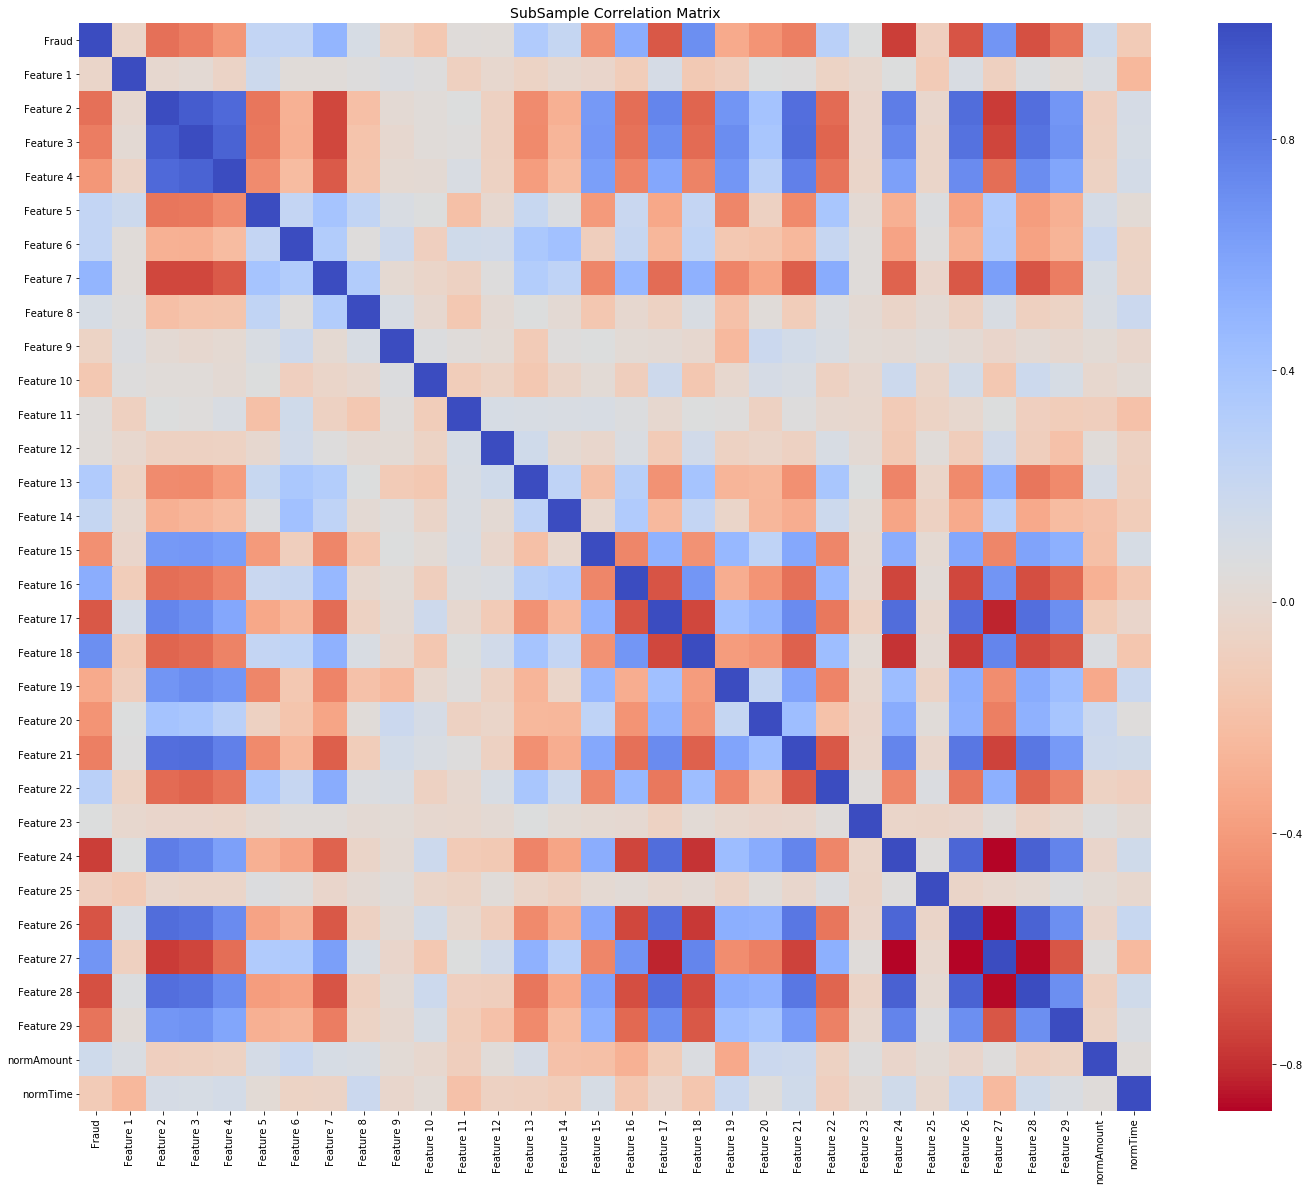

In [23]:
# Shuffle dataframe rows
df_sample = normal_distributed_df.sample(frac=1, random_state=42)

f, ax1 = plt.subplots(1, 1, figsize=(24,20))

sub_sample_corr = df_sample.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()

<b>Negative Correlations</b>: Features (7 and 8), (15 and 16), (16 and 17), (16 and 21), (24 and 27), (26 and 27) are negatively correlated. <br/>
<b>Positive Correlations</b>:Features (2,3, and 4), (2 and 26), (15 and 21) are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

So now we will be removing features 7, 16, 27, 2, 21

In [24]:
normal_distributed_df.drop(['Feature 2', 'Feature 3', 'Feature 7', 'Feature 16', 'Feature 18', 'Feature 21', 'Feature 27'], axis=1, inplace=True)
df.drop(['Feature 2', 'Feature 3', 'Feature 7', 'Feature 16', 'Feature 18', 'Feature 21', 'Feature 27'], axis=1, inplace=True)

## Random Forest 

In [25]:
y_small = normal_distributed_df['Fraud']
X_small = normal_distributed_df.drop('Fraud', axis=1)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, train_size=0.7, random_state=0)

y = df['Fraud']
X = df.drop('Fraud', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [26]:
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=17,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy')

# Perform SFFS
sfs1 = sfs1.fit(X_train_small, y_train_small)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   35.7s finished

[2019-03-16 13:49:10] Features: 1/17 -- score: 0.8730257678829106[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   26.9s finished

[2019-03-16 13:49:37] Features: 2/17 -- score: 0.939553081838796[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   24.7s finished

[2019-03-16 13:50:01] Features: 3/17 -- score: 0.9395534941249227[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [28]:
# Get the features that were selected as predictors
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 15, 16, 17, 21, 22, 23]


In [29]:
# Build full model with selected features
clf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4)
clf.fit(X_train.iloc[:, feat_cols], y_train)

y_train_pred = clf.predict(X_train.iloc[:, feat_cols])
print('Training accuracy on selected features: %.3f' % accuracy_score(y_train, y_train_pred))

y_test_pred = clf.predict(X_test.iloc[:, feat_cols])
print('Testing accuracy on selected features: %.3f' % accuracy_score(y_test, y_test_pred))

KeyboardInterrupt: 

In [ ]:
# Build full model with selected features
clf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Training accuracy on selected features: %.3f' % accuracy_score(y_train, y_train_pred))

y_test_pred = clf.predict(X_test)
print('Testing accuracy on selected features: %.3f' % accuracy_score(y_test, y_test_pred))

Therefore, we will be moving forward with these features only

In [ ]:
X_train = X_train.iloc[:, feat_cols]
X_test = X_test.iloc[:, feat_cols]

## T-SNE

In [30]:
# New_df is from the random undersample data (fewer instances)
# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

X = new_df.drop('Fraud', axis=1)
y = new_df['Fraud']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

T-SNE took 4.9 s


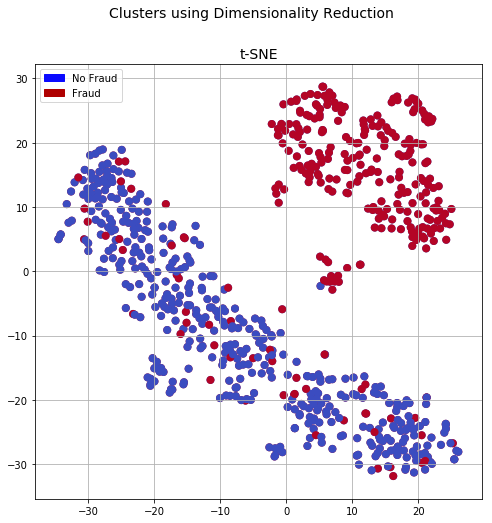

In [31]:
f, ax1 = plt.subplots(1, 1, figsize=(8,8))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

plt.show()

# Data Resampling

In [32]:
#Function to plot data. Will be used later
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [33]:
method = SMOTE(kind='regular')

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

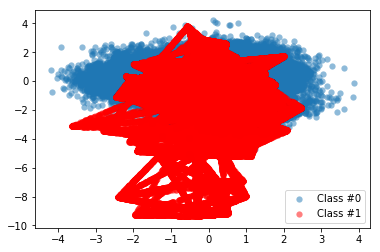

numpy.ndarray

In [34]:
plot_data(X_resampled, y_resampled)
type(X_resampled)

In [35]:
print("Before resampling")
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print("After resampling")
print(pd.value_counts(pd.Series(y_resampled)))

Before resampling
0.0    417
1.0    293
Name: Fraud, dtype: int64
After resampling
1.0    153599
0.0    153599
dtype: int64


## Models to detect Fraud

## Use Decision Tree 

In [40]:
model_dt = DecisionTreeClassifier(random_state=5)

# Fit the model to our resampled dataset
model_dt.fit(X_train, y_train)

# Obtain predictions from the test data 
predicted = model_dt.predict(X_test)

# Print the accuracy performance metric
# print(accuracy_score(y_test, predicted))

# Predict probabilities
probs = model_dt.predict_proba(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print("F SCORE", f1_score(y_test, predicted))

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     65831
         1.0       0.69      0.65      0.67        86

   micro avg       1.00      1.00      1.00     65917
   macro avg       0.85      0.83      0.84     65917
weighted avg       1.00      1.00      1.00     65917

Confusion matrix:
 [[65806    25]
 [   30    56]]
F SCORE 0.6706586826347306


### Random Forest

Random Forest before resampling:

In [36]:
model_rf = RandomForestClassifier(random_state=5)

# Fit the model to our resampled dataset
model_rf.fit(X_train, y_train)

# Obtain predictions from the test data 
predicted = model_rf.predict(X_test)

# Print the accuracy performance metric
# print(accuracy_score(y_test, predicted))

# Predict probabilities
probs = model_rf.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))
print("F SCORE", f1_score(y_test, predicted))

C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9124292188631001
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     65831
         1.0       0.94      0.70      0.80        86

   micro avg       1.00      1.00      1.00     65917
   macro avg       0.97      0.85      0.90     65917
weighted avg       1.00      1.00      1.00     65917

[[65827     4]
 [   26    60]]
F SCORE 0.8000000000000002


Random Forest after resampling

In [37]:
# Define the model as the random forest
model_rf_re = RandomForestClassifier(random_state=5)

# Fit the model to our resampled dataset
model_rf_re.fit(X_resampled, y_resampled)

# Obtain predictions from the test data 
predicted = model_rf_re.predict(X_test)

# Predict probabilities
probs = model_rf_re.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))
print("F SCORE", f1_score(y_test, predicted))

C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9276659084413824
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     65831
         1.0       0.92      0.77      0.84        86

   micro avg       1.00      1.00      1.00     65917
   macro avg       0.96      0.88      0.92     65917
weighted avg       1.00      1.00      1.00     65917

[[65825     6]
 [   20    66]]
F SCORE 0.8354430379746837


<div class="alert alert-success">
    Out of all the models employed, we will be using this one as it provides the best F score
</div>

## Plot learning curve

C:\Users\smart\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


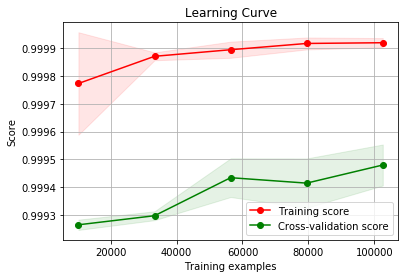

In [43]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title= "Learning Curve"
plot_learning_curve(model_rf, title, X_train, y_train)

plt.show()

From the learning curve, we can see that the bias-variance trade-off is not very bad and we'll continue with this model